## **Financial Sentiment Analysis**

Financial markets are highly sensitive to news. Manually interpreting large volumes of financial news is slow and inconsistent.
This project aims to automatically classify financial news headlines into:

Bullish (Positive), Bearish (Negative), or Neutral

so that investors, analysts, and trading systems can make faster and more informed decisions.

In [1]:
# Load and Inspect Data
import pandas as pd

df = pd.read_csv("all-data.csv", encoding='latin-1', names=['sentiment','headline'])

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


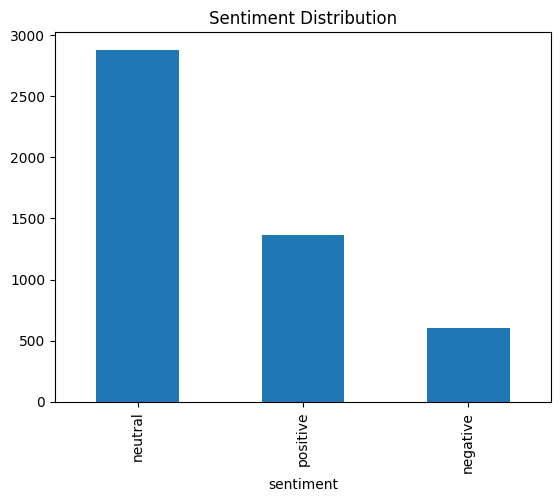

In [2]:
# Class Distribution
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()


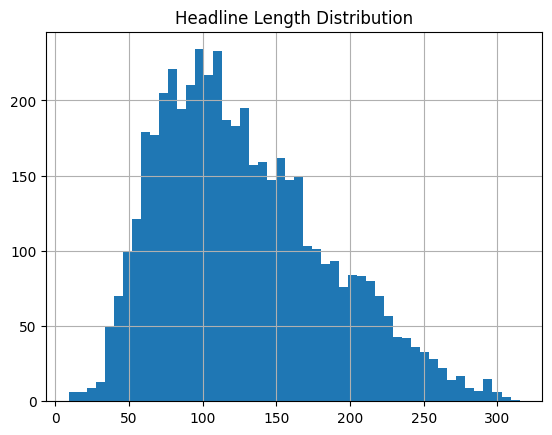

In [3]:
# Headline Length Analysis
df['length'] = df['headline'].apply(len)

df['length'].describe()

df['length'].hist(bins=50)
plt.title("Headline Length Distribution")
plt.show()


In [4]:
# Frequent Keywords per Sentiment
from sklearn.feature_extraction.text import CountVectorizer

for s in df['sentiment'].unique():
    text = df[df['sentiment']==s]['headline']
    vec = CountVectorizer(stop_words='english', max_features=10)
    X = vec.fit_transform(text)
    print(f"\nTop words for {s}:")
    print(vec.get_feature_names_out())



Top words for neutral:
['business' 'company' 'eur' 'finland' 'finnish' 'group' 'million' 'new'
 'said' 'sales']

Top words for negative:
['company' 'eur' 'finnish' 'mn' 'net' 'operating' 'period' 'profit'
 'sales' 'year']

Top words for positive:
['company' 'eur' 'finnish' 'million' 'mn' 'net' 'profit' 'said' 'sales'
 'year']


In [5]:
# Text Preprocessing

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(words)

df['clean'] = df['headline'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df['clean']
y = df['sentiment']

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vec = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
# Baseline Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB()
}


In [9]:
# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"\n{name}")
    print(classification_report(y_test, preds))



Logistic Regression
              precision    recall  f1-score   support

    negative       0.78      0.38      0.51       121
     neutral       0.73      0.93      0.82       576
    positive       0.69      0.45      0.55       273

    accuracy                           0.73       970
   macro avg       0.73      0.59      0.63       970
weighted avg       0.73      0.73      0.70       970


SVM
              precision    recall  f1-score   support

    negative       0.64      0.52      0.57       121
     neutral       0.78      0.87      0.82       576
    positive       0.70      0.59      0.64       273

    accuracy                           0.75       970
   macro avg       0.71      0.66      0.68       970
weighted avg       0.74      0.75      0.74       970


Naive Bayes
              precision    recall  f1-score   support

    negative       0.80      0.23      0.36       121
     neutral       0.72      0.94      0.81       576
    positive       0.64      0.42   

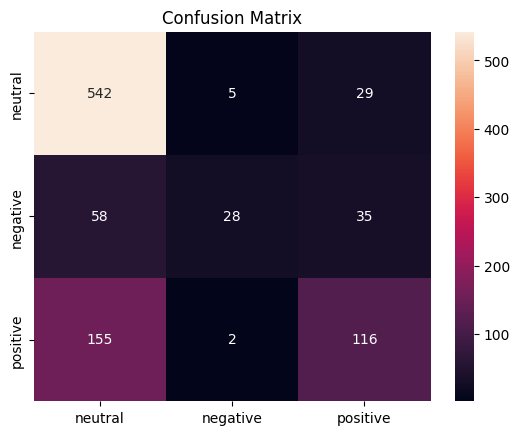

In [10]:
# Confusion Matrix
import seaborn as sns

cm = confusion_matrix(y_test, preds, labels=df['sentiment'].unique())
sns.heatmap(cm, annot=True, fmt='d', xticklabels=df['sentiment'].unique(),
            yticklabels=df['sentiment'].unique())
plt.title("Confusion Matrix")
plt.show()


**Model Evaluation & Comparison**

Test Set Size: 970 headlines
Classes: Negative | Neutral | Positive

Model Performance Summary
| Model               | Accuracy | Macro F1 | Weighted F1 |
| ------------------- | -------- | -------- | ----------- |
| Logistic Regression | **0.73** | 0.63     | 0.70        |
| **SVM (Linear)**    | **0.75** | **0.68** | **0.74**    |
| Naive Bayes         | 0.71     | 0.56     | 0.67        |

Best Overall Model: Linear SVM

**Detailed Interpretation**

**Neutral Class (Majority class)**

All models perform very well on Neutral:

SVM: F1 = 0.82

Logistic: F1 = 0.82

NB: F1 = 0.81

This is expected since most financial news is informational rather than opinionated.

**Positive (Bullish) Sentiment**
| Model    | Precision | Recall   | F1       |
| -------- | --------- | -------- | -------- |
| Logistic | 0.69      | 0.45     | 0.55     |
| **SVM**  | **0.70**  | **0.59** | **0.64** |
| NB       | 0.64      | 0.42     | 0.51     |

SVM captures bullish signals far better — critical for trading decisions.

**Negative (Bearish) Sentiment**
| Model    | Precision | Recall   | F1       |
| -------- | --------- | -------- | -------- |
| Logistic | 0.78      | 0.38     | 0.51     |
| **SVM**  | **0.64**  | **0.52** | **0.57** |
| NB       | 0.80      | 0.23     | 0.36     |

Naive Bayes is too conservative → misses most bearish news (low recall).

Logistic Regression is too cautious on detecting negatives.

SVM finds the best balance between precision & recall.

**Final Model Recommendation**

**Recommended Model: Linear SVM + TF-IDF**

Why SVM wins:

Highest overall accuracy (75%)

Best macro F1 (balanced across all classes)

Strongest detection of positive & negative sentiment

Stable on sparse financial text features

This model is best suited for real-world financial decision systems where missing bearish or bullish signals is costly.

**Business Implications**

Using the SVM model:

Bullish news detected earlier → better entry points

Bearish risk flagged faster → improved downside protection

Neutral filtering → reduces noise for analysts

**Example Business Impact**

“Automated sentiment classification improves market reaction speed by minutes, enabling more responsive trading strategies and risk control.”